In [3]:
import os, sys
import numpy as np
import pandas as pd
import EMdata
import torch
import itertools
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time

In [4]:
#GPU or CPU
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev) 

In [92]:
#data path
file_path='F:/script/class2vec/real_star_file/P301L_chen_ferritin_ig_select.star'
datatype=0 #0 is relion 3.1, 1 is relion 3, 2 is cryosparc
block_size=64

file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
if os.path.isdir(output_path) is False:
    os.mkdir(output_path)

In [93]:
if datatype<2:
    file_info=EMdata.read_relion(file_path)
    if datatype==0:
        #read data (relion3.1)
        dataset=file_info.getRdata_31()
        optics=file_info.extractoptic()
    else:
        #read relion 3.0
        dataset=file_info.getRdata()
    metadata=dataset[0]
    print(metadata)
    data=dataset[1]
    print(data[0])
    corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
else:
    #read cryosparc
    dataset=np.load(file_path)
    corpus_information=EMdata.process_cryosparc_helical(dataset).extract_helical()
corpus_dic,helix_name=corpus_information
corpus=list(corpus_dic.values())
corpus_backup=corpus[:]

['_rlnCoordinateX', '_rlnCoordinateY', '_rlnHelicalTubeID', '_rlnAngleTiltPrior', '_rlnAnglePsiPrior', '_rlnHelicalTrackLengthAngst', '_rlnAnglePsiFlipRatio', '_rlnImageName', '_rlnMicrographName', '_rlnOpticsGroup', '_rlnCtfMaxResolution', '_rlnCtfFigureOfMerit', '_rlnDefocusU', '_rlnDefocusV', '_rlnDefocusAngle', '_rlnCtfBfactor', '_rlnCtfScalefactor', '_rlnPhaseShift', '_rlnGroupNumber', '_rlnAngleRot', '_rlnAngleTilt', '_rlnAnglePsi', '_rlnOriginXAngst', '_rlnOriginYAngst', '_rlnClassNumber', '_rlnNormCorrection', '_rlnLogLikeliContribution', '_rlnMaxValueProbDistribution', '_rlnNrOfSignificantSamples']
['1090.065569', '1853.500631', '1', '90.000000', '-124.37213', '584.250000', '0.500000', '000042@Extract/job014/micrographs/19mar27a_AuTau3-23_00012gr_00007sq_00002hl_00002es-a-DW.mrcs', 'micrographs/19mar27a_AuTau3-23_00012gr_00007sq_00002hl_00002es-a-DW.mrc', '1', '3.735417', '0.419126', '21706.958984', '21511.396484', '-25.82986', '0.000000', '1.000000', '0.000000', '1', '0.00000

In [94]:
# cryosparc
#corpus_ignore=corpus

In [95]:
corpus_ignore=[]
for i in range(len(corpus)):
    corpus_row=[]
    count=1
    lst=corpus[i]
    for j in range(len(lst)):
        particle=lst[j]
        if j==0:
            count+=particle[1]-1
        if count==int(particle[1]):
            corpus_row.append(str(particle[0]))
            count+=1
        else:
            while 1:
                if count==int(lst[j][1]):
                    corpus_row.append(str(particle[0]))
                    count+=1
                    break
                corpus_row+=['0']
                count+=1               
    corpus_ignore.append(corpus_row)

189


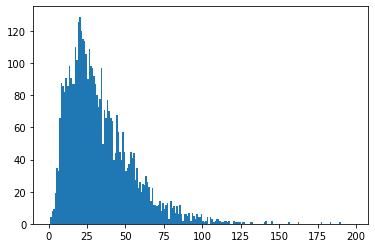

In [96]:
corpus_length_histogram=[]
for i in range(len(corpus_ignore)):
    corpus_length_histogram.append(len(corpus_ignore[i]))
plt.hist(corpus_length_histogram,list(range(0,max(corpus_length_histogram)+10,1)))
#plt.ylim((0,1000))
print(max(corpus_length_histogram))
plt.show()

In [97]:
vocabulary = set(itertools.chain.from_iterable(corpus_ignore))
vocabulary_size = len(vocabulary)
print(vocabulary_size)

28


In [98]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [99]:
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer
if os.path.isdir(output_path+"/corpus") is False:
    os.mkdir(output_path+"/corpus")
paths = [str(x) for x in Path(output_path+"/corpus/").glob("**/*.txt")]

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=paths, vocab_size=vocabulary_size, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])
if os.path.isdir(output_path+"/tokens") is False:
    os.mkdir(output_path+"/tokens")
if os.path.isdir("./tokens") is False:
    os.mkdir("./tokens")
tokenizer.save_model(output_path+"/tokens")
tokenizer.save_model("./tokens")

['./tokens\\vocab.json', './tokens\\merges.txt']

In [100]:
import json

with open(output_path+'/tokens/vocab.json') as f:
    decode = json.load(f)
encode={value:key for (key, value) in decode.items()}


In [101]:
corpus_code=[]
for i in range(len(corpus_ignore)):
    lst=corpus_ignore[i]
    corpus_row=[]
    for j in range(len(lst)):
        corpus_row.append(encode[word_to_index[lst[j]]+5])
    corpus_code.append(corpus_row)

In [102]:
lst[j]

'2'

In [103]:
with open(output_path+"/corpus/helical.txt","w") as f:
    for i in range(len(corpus_code)):
        lst=corpus_code[i]
        for j in range(len(lst)):
            if j==len(lst)-1:
                f.write(lst[j]+'\n')
            else:
                f.write(lst[j])

In [104]:
if '0' in [i for i in vocabulary]:
    del decode[encode[word_to_index['0']+5]]
    print('delete the ignored group',print(encode[word_to_index['0']+5]))
with open('./tokens/vocab.json','w') as f:
    json.dump(decode,f)
with open(output_path+'/tokens/vocab.json','w') as f:
    json.dump(decode,f)

<
delete the ignored group None


In [105]:
from transformers import RobertaTokenizerFast, BartTokenizer

tokenizer = BartTokenizer.from_pretrained(output_path+"/tokens", max_len=514)
#tokenizer.encode(encode[word_to_index['0']+5])

In [106]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=50_000,
    max_position_embeddings=128,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [107]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)

In [108]:
%%time
from transformers import LineByLineTextDataset

data_import = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=output_path+"/corpus/helical.txt",
    block_size=block_size,
)

Wall time: 772 ms


In [109]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [110]:
from transformers import Trainer, TrainingArguments


trainer = Trainer(
    model=model,
    data_collator=data_collator,
    train_dataset=data_import,
    prediction_loss_only=True,
)

D:\ProgramData\Anaconda3\lib\site-packages\transformers\trainer.py:247: FutureWarning: Passing `prediction_loss_only` as a keyword argument is deprecated and won't be possible in a future version. Use `args.prediction_loss_only` instead.
  FutureWarning,


In [111]:
trainer.train()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/563 [00:00<?, ?it/s]

{'loss': 3.3223642578125, 'learning_rate': 3.5198342214328006e-05, 'epoch': 0.8880994671403197, 'step': 500}


D:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Iteration:   0%|          | 0/563 [00:00<?, ?it/s]

{'loss': 2.14210888671875, 'learning_rate': 2.039668442865601e-05, 'epoch': 1.7761989342806395, 'step': 1000}


Iteration:   0%|          | 0/563 [00:00<?, ?it/s]

{'loss': 1.97198583984375, 'learning_rate': 5.595026642984015e-06, 'epoch': 2.664298401420959, 'step': 1500}


TrainOutput(global_step=1689, training_loss=2.404771279695826)

In [112]:
trainer.save_model(output_path+"/tokens/")
trainer.save_model("./tokens/")

In [113]:
from transformers import pipeline

feature_extraction = pipeline(
    'feature-extraction',model="./tokens",tokenizer="./tokens")

In [114]:
#print(np.shape(feature_extraction(encode[word_to_index['50']+5])))
#print(np.squeeze(feature_extraction('DGG'))[0]-np.squeeze(feature_extraction('JJ'))[0])
print(len(''.join(corpus_code[2])))
print(len(corpus_ignore[2]))

56
56


In [115]:
def cut_corpus(corpus,cut_length):
    cut_index=[]
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<=cut_length:
            new_corpus.append(lst)
            continue
        if n%cut_length==0:
            cut_amount=int(n/cut_length)
        else:
            cut_amount=int((n-n%cut_length)/cut_length)+1
        for j in range(cut_amount-1):
            cut_index.append(i)
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus,cut_index
corpus_code_cut,cut_index=cut_corpus(corpus_code,block_size-2)

4497
4942


In [116]:
filament_embeddings=[]
for i in range(len(corpus_code_cut)):
    if i%200==0:
        print(i)
    lst=list(np.squeeze(feature_extraction(''.join(corpus_code_cut[i])))[0])
    filament_embeddings.append(lst)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800


In [117]:
import umap
import sklearn
from sklearn.cluster import KMeans,SpectralClustering,MeanShift, estimate_bandwidth,DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal 
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

In [118]:
filament_embeddings=np.array(filament_embeddings)
mask_1 = np.isfinite(filament_embeddings).all(axis=1)

In [119]:
len(filament_embeddings[mask_1])

4942

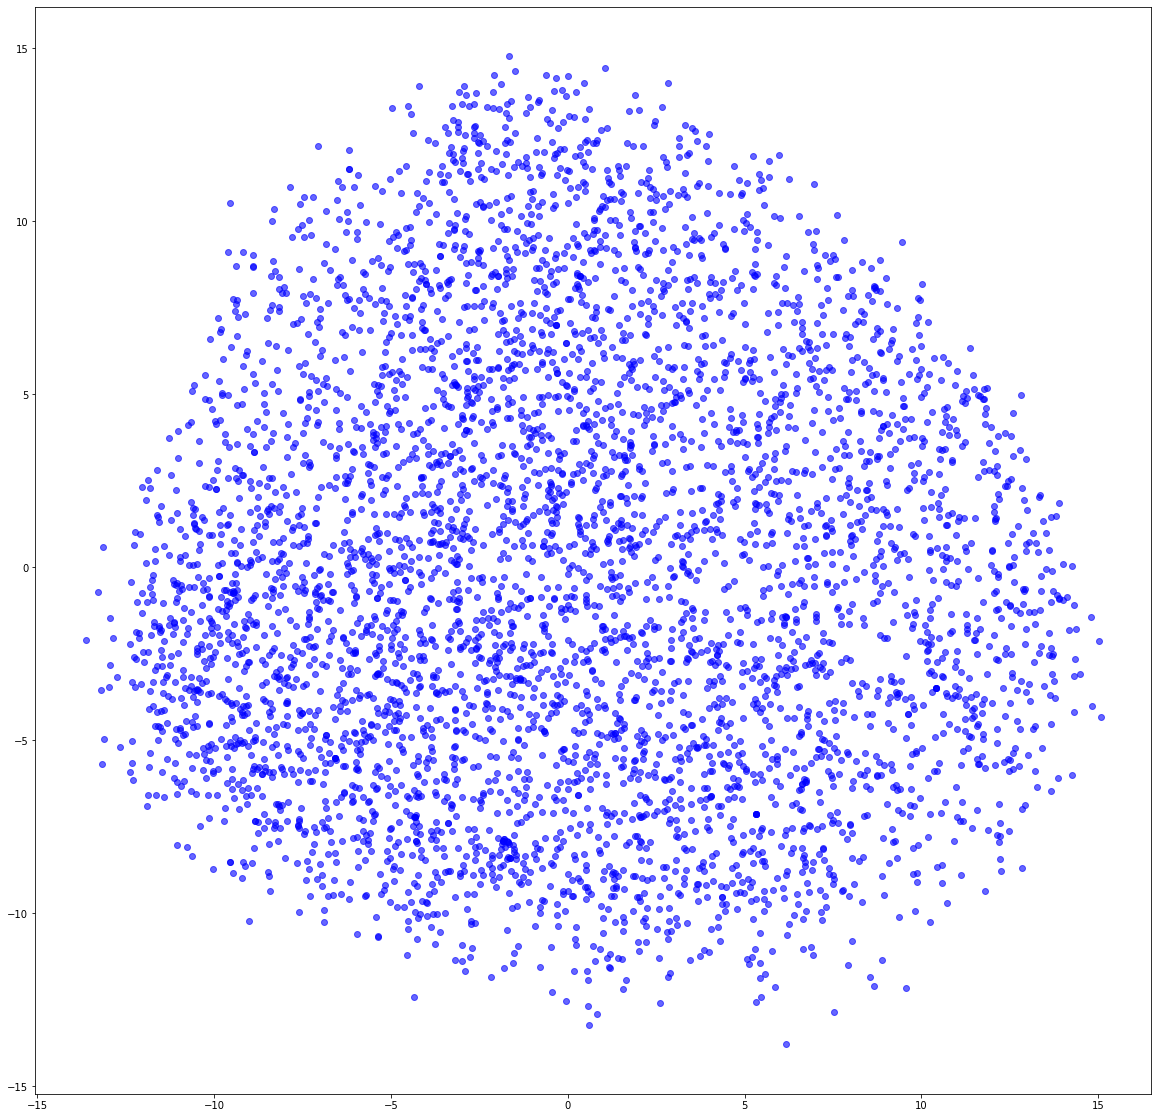

In [120]:
pca_sum = PCA(n_components=2).fit_transform(filament_embeddings)
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])
pca_sum_hD = PCA(n_components=30).fit_transform(filament_embeddings)

plt.figure(figsize = (20, 20))
plt.scatter(pca_sum[:,0], pca_sum[:,1],alpha=0.6,color='blue')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [121]:
%%time
n_neighbors=10
min_dist=0.05
#umap_ND=umap.UMAP(n_neighbors=200,min_dist=0.4,n_components=100).fit_transform(filament_embeddings)
reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
umap_2D = reducer.fit_transform(filament_embeddings)
umap_ND=umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=100).fit_transform(filament_embeddings)
print('finish umap')

finish umap
Wall time: 8.06 s


In [122]:
with open(output_path+'/'+'umap_3D_bert.npy', 'wb') as f:
    np.save(f, umap_ND)

In [123]:
filament_cluster_number=2
umap_predict=KMeans(n_clusters=filament_cluster_number).fit_predict(umap_ND)
#umap_predict=DBSCAN(eps=0.52, min_samples=100).fit_predict(umap_2D)+1
#filament_cluster_number=len(np.unique(umap_predict))

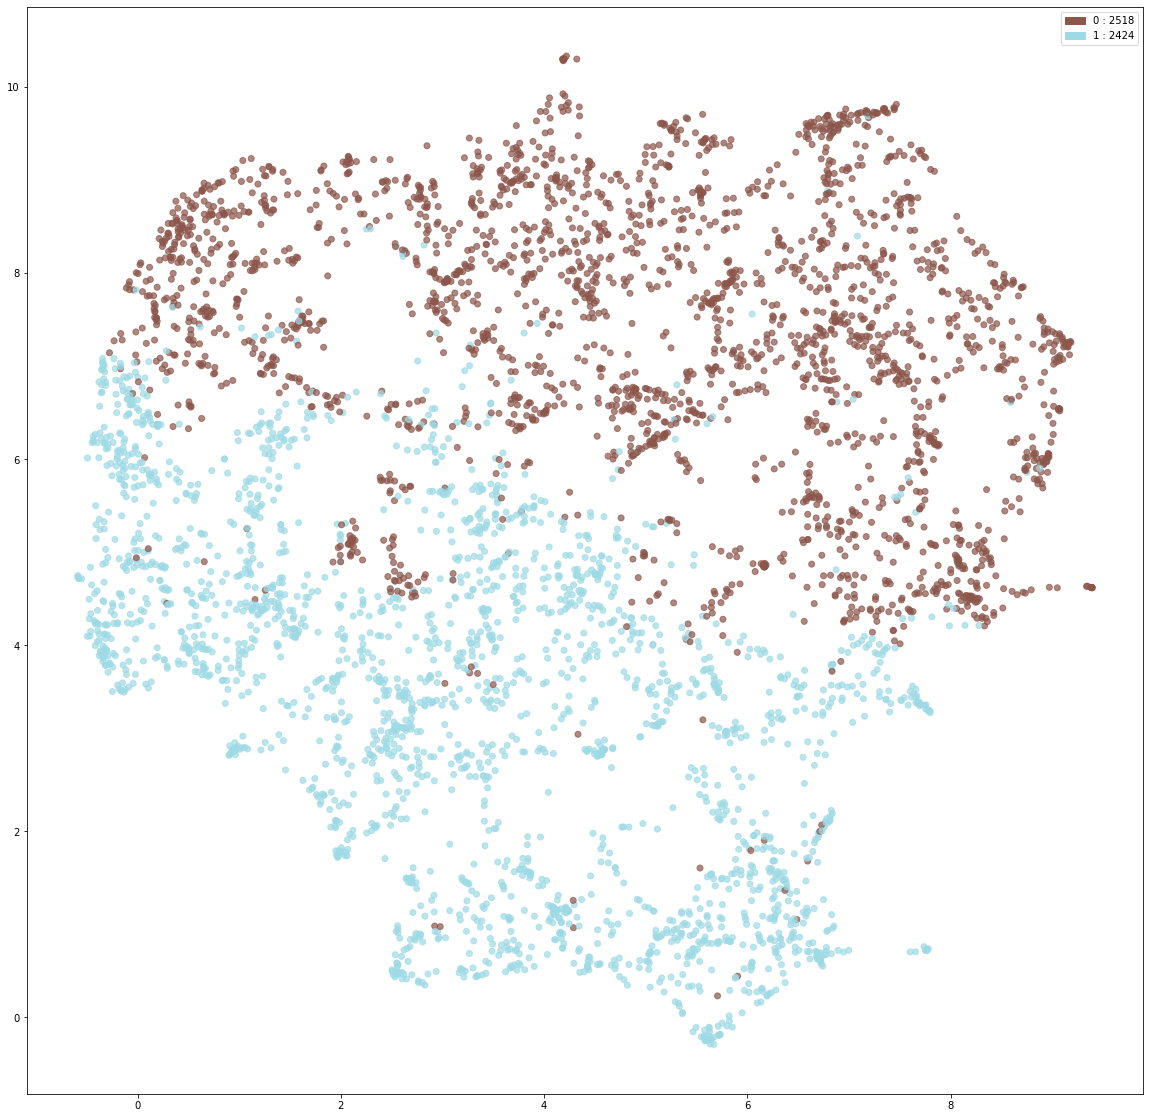

In [124]:
plt.figure(figsize = (20, 20))

for i in range(filament_cluster_number):
    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i+1)/filament_cluster_number), 
                                             label=str(i)+' : '+str(np.count_nonzero(umap_predict==i)))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
#plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.6,c=plt.cm.tab20((umap_predict)/filament_cluster_number))
plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.7,c=plt.cm.tab20((umap_predict+1)/filament_cluster_number))
#plt.xlim((-5,15))
#plt.ylim((0,15))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_umap.png",bbox_inches='tight', pad_inches=0.01)
#c=plt.cm.tab20((umap_predict+1)/filament_cluster_number)

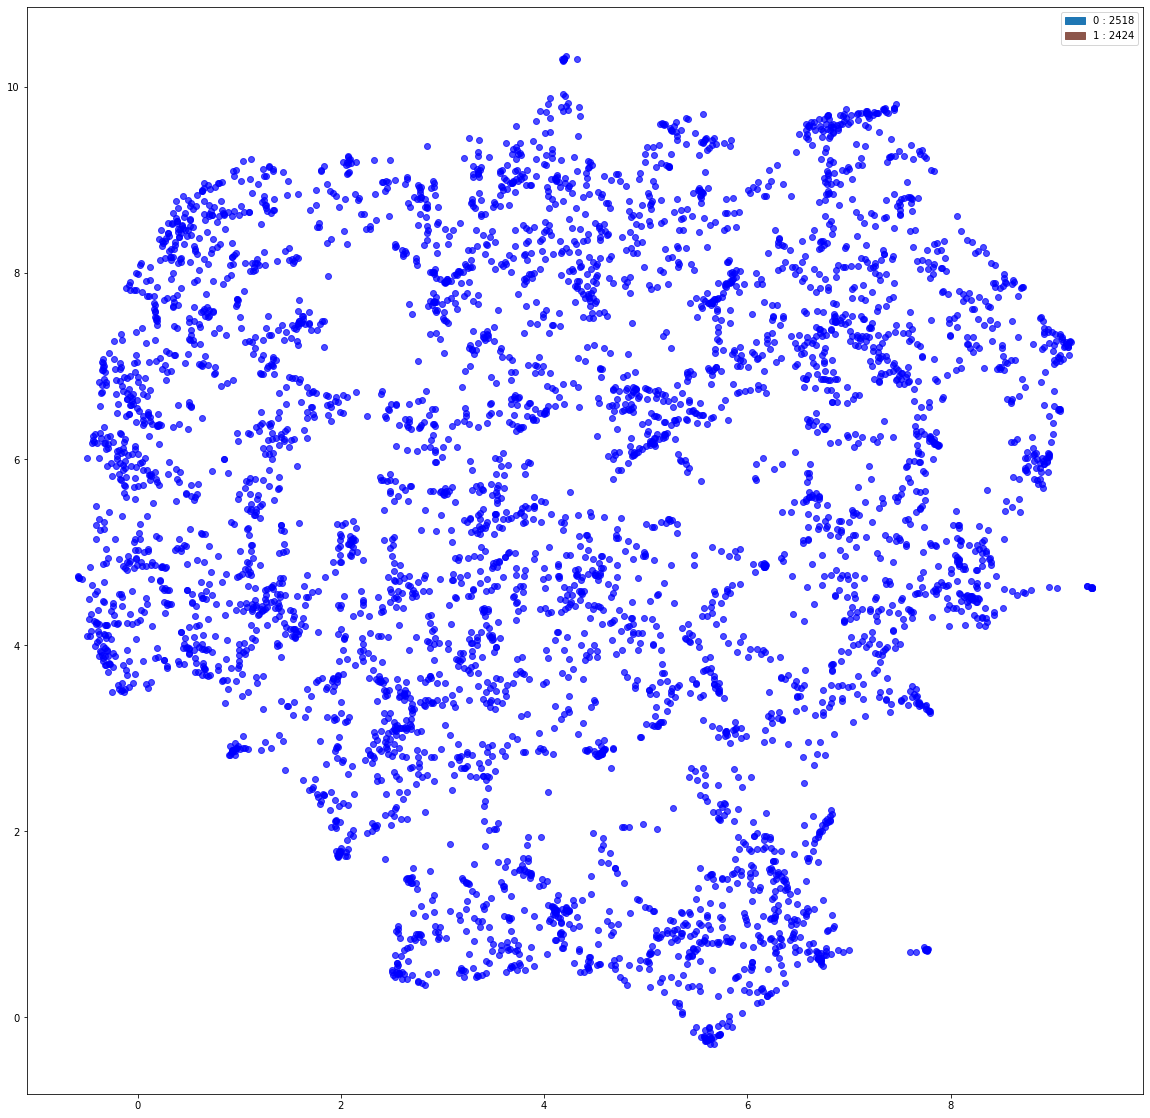

In [125]:
plt.figure(figsize = (20, 20))

for i in range(filament_cluster_number):
    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i)/filament_cluster_number), 
                                             label=str(i)+' : '+str(np.count_nonzero(umap_predict==i)))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
#plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.6,c=plt.cm.tab20((umap_predict)/filament_cluster_number))
plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.7,c='blue')
#plt.xlim((-5,15))
#plt.ylim((0,15))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_umap_blue.png",bbox_inches='tight', pad_inches=0.01)
#c=plt.cm.tab20((umap_predict+1)/filament_cluster_number)

In [88]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]

cluster_choice=umap_predict
positive_label=[]
cut_index=np.array(cut_index)
for i in range(len(helix_name)):
    if i in cut_index:
        t=np.count_nonzero(cut_index==i)
        while t>0:
            positive_label.append(helix_name[i][11:14])
            t-=1
    positive_label.append(helix_name[i][11:14])
positive_label=np.array(positive_label)
labels=list(np.unique(positive_label))
positive_label_new=np.array([float(labels.index(x)) for x in positive_label])
labels_name=['type 3','type 1B','type 2B','type 1A','type 2A','type 2AB'] # define the type of filaments 
clustersize=[]
for i in range(filament_cluster_number):
    clustersize.append(len(locals()['cluster'+str(i)]))
print(positive_label_new[2])
print(labels)

0.0
['014']


In [89]:
helix_name[0]

'Extract/job014/micrographs/19mar27a_AuTau3-23_00012gr_00007sq_00002hl_00002es-a-DW.mrcs-1'

In [90]:
np.count_nonzero(cut_index==126)

0

4957


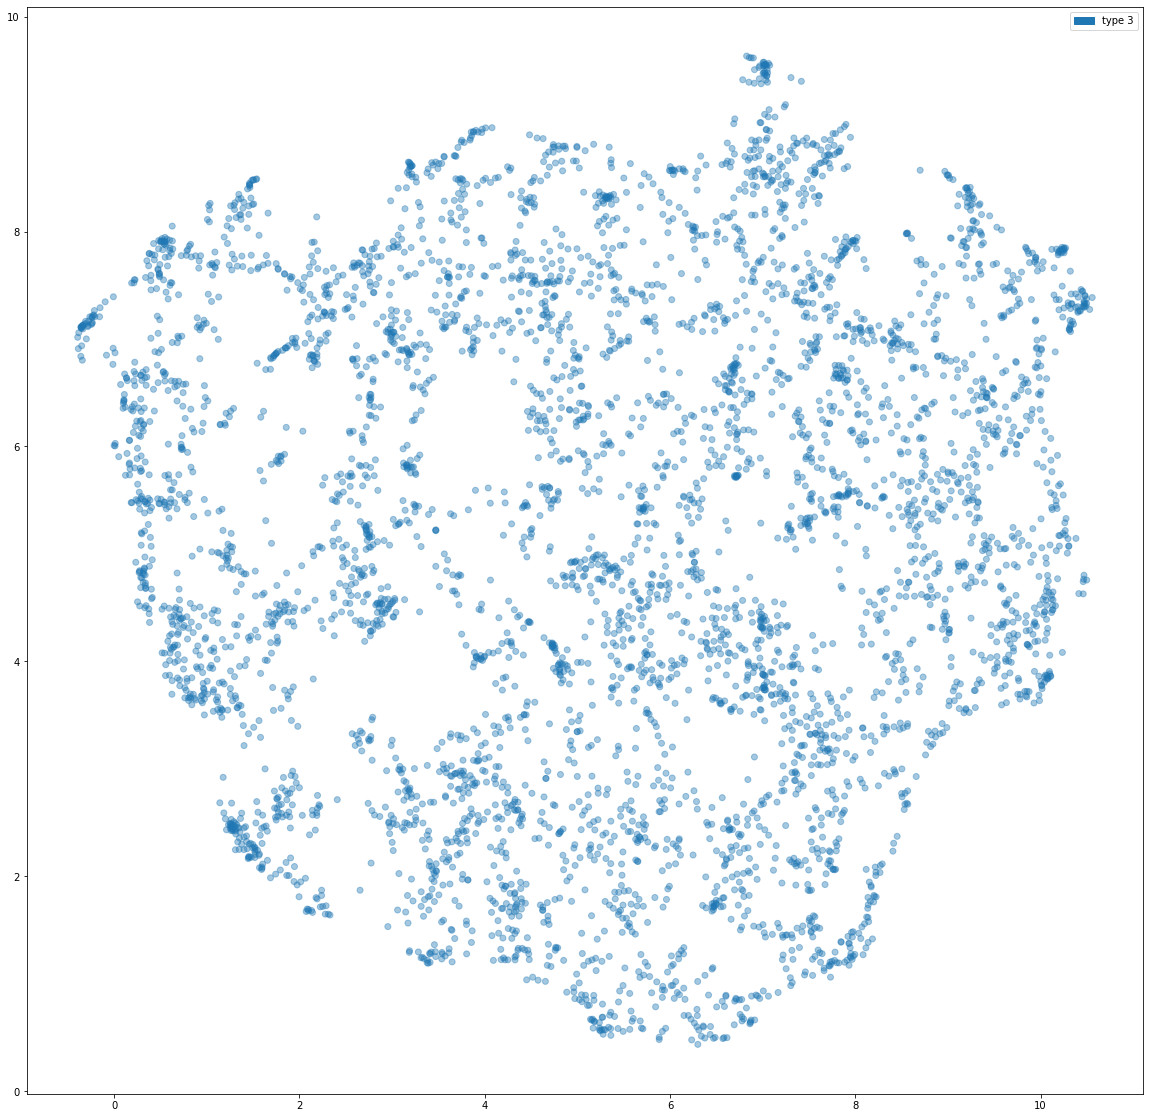

In [91]:
plt.figure(figsize = (20, 20))
for i in range(len(labels_name)):
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/20), label=labels_name[i])
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(labels))])
print(len(positive_label))
plt.scatter(umap_2D[:,0], umap_2D[:,1],color=plt.cm.tab20(positive_label_new/20),alpha=0.4)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_label_bert.png",bbox_inches='tight', pad_inches=0.01)

In [41]:
print(len(positive_label_new),len(cluster_choice))
hist_data=pd.DataFrame({'labels':positive_label_new,'predict':cluster_choice})
distribution_hist_all=[]

for i in range(1,filament_cluster_number+1):
    distribution=[]
    lst=hist_data[hist_data['labels']==i]
    for j in range(len(labels)):
        distribution.append(len(lst[lst['predict']==j])/len(lst))
    distribution_hist_all.append(distribution)
print(distribution_hist_all)



4259 4259


ZeroDivisionError: division by zero

In [ ]:
fig, ax = plt.subplots(1,filament_cluster_number,figsize = (5*filament_cluster_number,7))
for i in range(filament_cluster_number):
    ax[i].bar(range(len(labels)),distribution_hist_all[i],tick_label =labels_name)
    particle_number=len(locals()['cluster'+str(i)])
    ax[i].set_title('cluster{} amount: {}'.format(i,particle_number))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new_bert.png')
print('a')

In [ ]:
for i in range(filament_cluster_number):
    locals()['cluster'+str(i)]=[]
    locals()['clusterID'+str(i)]=[]
for i in range(len(corpus)):
    labels=umap_predict[i]
    locals()['clusterID'+str(labels)].append(i)
    lst=corpus[i]
    for j in range(len(lst)):
        dataline=lst[j][-1]
        locals()['cluster'+str(labels)].append(data[dataline])

In [ ]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if datatype==0:
        output=EMdata.output_star(output_path+'/bert_'+file_name,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    elif datatype==1:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()

In [ ]:
print(corpus[0])